**One Shot Learning with minimal training data using Siamese Network**

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax,LSTM, Lambda, GRU
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import math
from IPython.display import Audio
import os
import itertools
import pickle

In [4]:
directory= "/content/drive/My Drive/Deep_Learning/HW4/"

In [5]:
# loading the training and testing data
filename_tr='hw4_trs.pkl'
filename_te='hw4_tes.pkl'  

# reading train file
open_file = open(directory+filename_tr, "rb")
tr= pickle.load(open_file)
open_file.close()

# reading test file
open_file = open(directory+filename_te, "rb")
te= pickle.load(open_file)
open_file.close()

print("shape of training matrix", tr.shape)
print("shape of testing matrix", te.shape)

shape of training matrix (500, 16180)
shape of testing matrix (200, 22631)


STFT of all the training and testing signals

In [6]:
def stft(tr):
    tr_speakers=[]
    for i in range(len(tr)):
    tr_speakers.append(librosa.stft(tr[i,:], n_fft=1024, hop_length=512))
    return np.array(tr_speakers)

tr=stft(tr) # stft on training set
te=stft(te) # stft on test set
print("shape of initial training matrix", tr.shape)
print("shape of initial testing matrix", te.shape)

shape of initial training matrix (500, 513, 32)
shape of initial testing matrix (200, 513, 45)


In [7]:
## preprocessing for training set

S_tr = np.split(tr, 50)
S_te = np.split(te, 20)

S1= S_tr[0]
S1_pos = np.array(list(itertools.combinations(S1, 2))) # combination of positive occurences for S1
#print(S1_pos.shape)

L = len(S1_pos)
train_loader = []
for i in range(len(S_tr)):
    Si = S_tr[i]
    # positive examples - contains combination with itself [(.., ..), (.., ..), .......45 such tuples]
    Si_pos = np.array(list(itertools.combinations(Si, 2)))
    L = len(Si_pos)
    
    subset = np.concatenate((tr[0:10 * i], tr[(10 + i*10):]))
    
    set_1 = subset[np.random.choice(subset.shape[0], L, replace=True)]
    set_2 = Si[np.random.choice(Si.shape[0], L, replace=True)]

    final_set = []
    for i in range(len(set_1)):
        final_set.append((set_1[i], set_2[i]))
    first_neg = np.array(final_set)    
    
    first_minibatch = np.concatenate((S1_pos, first_neg))
    
    train_loader.append(first_minibatch)

train_loader=np.array(train_loader).reshape((4500,2,32,513))
tr_pair1= train_loader[:,0,:,:]
tr_pair2= train_loader[:,1,:,:]
print("Shape of training matrix of pair 1", tr_pair1.shape)
print("Shape of training matrix of pair 2", tr_pair2.shape)

Shape of training matrix of pair 1 (4500, 32, 513)
Shape of training matrix of pair 2 (4500, 32, 513)


In [8]:
# pairing for test set
S1= S_te[0]
S1_pos = np.array(list(itertools.combinations(S1, 2))) # combination of positive occurences for S1
#print(S1_pos.shape)

L = len(S1_pos)
train_loader = []
for i in range(len(S_te)):
    Si = S_te[i]
    # positive examples - contains combination with itself [(.., ..), (.., ..), .......45 such tuples]
    Si_pos = np.array(list(itertools.combinations(Si, 2)))
    L = len(Si_pos)
    
    subset = np.concatenate((te[0:10 * i], te[(10 + i*10):]))
    
    set_1 = subset[np.random.choice(subset.shape[0], L, replace=True)]
    set_2 = Si[np.random.choice(Si.shape[0], L, replace=True)]

    final_set = []
    for i in range(len(set_1)):
        final_set.append((set_1[i], set_2[i]))
    first_neg = np.array(final_set)    
    
    first_minibatch = np.concatenate((S1_pos, first_neg))
    
    train_loader.append(first_minibatch)

train_loader=np.array(train_loader).reshape((1800,2,45,513))
te_pair1= train_loader[:,0,:,:]
te_pair2= train_loader[:,1,:,:]
print("Shape of testing matrix of pair 1", te_pair1.shape)
print("Shape of testing matrix of pair 2", te_pair2.shape)

Shape of testing matrix of pair 1 (1800, 45, 513)
Shape of testing matrix of pair 2 (1800, 45, 513)


In [9]:
# creating Y matrix for training set
Y_tr=[]
ones=np.ones((45,1))
zeros=np.zeros((45,1))
for i in range(50):
  Y_tr.append(ones)
  Y_tr.append(zeros)
Y_tr=np.array(Y_tr).reshape((4500,1))
print("shape of Y train matrix",Y_tr.shape)

# creating Y matrix for test set
Y_te=[]
ones=np.ones((45,1))
zeros=np.zeros((45,1))
for i in range(20):
  Y_te.append(ones)
  Y_te.append(zeros)
Y_te=np.array(Y_te).reshape(1800,1)
print("shape of Y test matrix",Y_te.shape)

shape of Y train matrix (4500, 1)
shape of Y test matrix (1800, 1)


Creating the model architecture

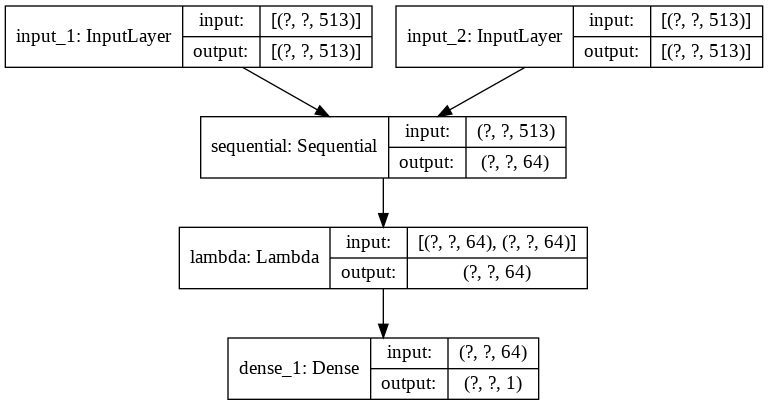

In [10]:
## constructing the LSTM network
def weights():
    initializer = tf.keras.initializers.HeNormal
    return initializer

ip1= keras.Input(shape=(None,513))
ip2= keras.Input(shape=(None,513))

model=Sequential()
model.add(LSTM(513, input_shape=(None,513),kernel_initializer=weights(), return_sequences=True))
#model.add(LSTM(1024,kernel_initializer=weights(),return_sequences=True))
#model.add(Flatten())
model.add(GRU(100,kernel_initializer=weights(), return_sequences=True))
model.add(GRU(64,kernel_initializer=weights(), return_sequences=True))
model.add(Dense(64, activation='relu'))

encoding_p1= model(ip1)
encoding_p2= model(ip2)

inter_layer= Lambda(lambda tensors: tf.multiply(tensors[0], tensors[1]))([encoding_p1,encoding_p2])

op= Dense(1, activation='sigmoid')(inter_layer)
siamese_net= keras.Model(inputs=[ip1,ip2],outputs=op)

keras.utils.plot_model(siamese_net,show_shapes=True)


In [11]:
#compiling the model
opt= tf.keras.optimizers.Adam()
siamese_net.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])
# training the model
history=siamese_net.fit([tr_pair1,tr_pair2],Y_tr,epochs=20,batch_size=50)

In [13]:
loss,acc= siamese_net.evaluate([te_pair1,te_pair2],Y_te,verbose=0)
print("test accuracy is", acc)

test accuracy is 0.7110863542556763
